In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import ipaddress

### Import the dataset as usual

In [3]:
df = pd.read_csv('./ProjectPrompt/ddos_dataset.csv',low_memory=False)
df.drop(df.columns[0],axis=1,inplace=True)
df.columns = df.columns.str.strip()
columns = df.columns[:-1]
df.head()


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,label
0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
1,172.16.0.5-192.168.50.1-60495-634-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ddos_dns
2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns


### Adding Features
Generate additional features that could be potentially useful like:
- Max,min,mean and standard deviation of flow duration, source port and destination port for each source ip
- Number of used protocols by each source ip address.
- Number of destination ports contacted
- Number of destination ip contacted


In [4]:
#*******************************************ADDING NEW FEATURES**************************************

def distinct(x):
    return len(set(x))

#Adding new features. For each src ip add number of protocols utilized, number of dst ports contacted, number of dst ips contacted it

add_f1 = df.groupby('Source IP').agg({
    'Protocol':distinct,
    'Destination Port':distinct,
    'Destination IP':distinct,
})
add_f1.rename(columns={'Protocol':'Used Protocols','Destination Port':'Contacted Ports','Destination IP':'Contacted IPs'},inplace=True)

#Adding new features. For each src ip add min max mean std of flow duration, source port, destination port
add_f2 = df[['Source IP','Flow Duration','Source Port','Destination Port']].groupby('Source IP')[['Flow Duration','Source Port','Destination Port']].agg(['min','max','mean','std']).fillna(0)
# print(add_f2.columns)
add_f2.columns  = [f'{feature} {statistic}' for feature,statistic in add_f2.columns]
# print(add_f2.columns)
newFeatures = add_f1.reset_index().merge(add_f2.reset_index(),on='Source IP',how='inner')

df = df.merge(newFeatures,on='Source IP',how='inner')
# df.iloc[:,80:]
df
# newFeatures


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Flow Duration mean,Flow Duration std,Source Port min,Source Port max,Source Port mean,Source Port std,Destination Port min,Destination Port max,Destination Port mean,Destination Port std
0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,0,...,4.697363e+06,2.162357e+07,0,65518,23609.178122,24131.348102,0,65535,32624.997827,19166.470310
1,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,0,...,4.697363e+06,2.162357e+07,0,65518,23609.178122,24131.348102,0,65535,32624.997827,19166.470310
2,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,0,...,4.697363e+06,2.162357e+07,0,65518,23609.178122,24131.348102,0,65535,32624.997827,19166.470310
3,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,0,...,4.697363e+06,2.162357e+07,0,65518,23609.178122,24131.348102,0,65535,32624.997827,19166.470310
4,172.16.0.5-192.168.50.1-634-47149-17,172.16.0.5,634,192.168.50.1,47149,17,2018-12-01 10:51:39.942030,46469,200,0,...,4.697363e+06,2.162357e+07,0,65518,23609.178122,24131.348102,0,65535,32624.997827,19166.470310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,192.168.50.6-35.186.239.238-56379-443-6,35.186.239.238,443,192.168.50.6,56379,6,2018-12-01 09:38:03.438913,903,3,2,...,8.410000e+02,8.768124e+01,443,443,443.000000,0.000000,56379,56381,56380.000000,1.414214
64235,192.168.50.6-35.186.239.238-56381-443-6,35.186.239.238,443,192.168.50.6,56381,6,2018-12-01 09:38:03.439033,779,3,2,...,8.410000e+02,8.768124e+01,443,443,443.000000,0.000000,56379,56381,56380.000000,1.414214
64236,192.168.50.6-23.194.141.200-56388-443-6,23.194.141.200,443,192.168.50.6,56388,6,2018-12-01 09:38:08.445142,4,3,0,...,1.520000e+02,2.093036e+02,443,443,443.000000,0.000000,56388,56388,56388.000000,0.000000
64237,192.168.50.6-23.194.141.200-56388-443-6,23.194.141.200,443,192.168.50.6,56388,6,2018-12-01 09:38:08.445146,300,1,2,...,1.520000e+02,2.093036e+02,443,443,443.000000,0.000000,56388,56388,56388.000000,0.000000


### Correlation analysis
Perform correlation analysis through correlation matrix.

To perform this task we need to convert the categorical features into numerical one in order to be able to calculate distances correctly

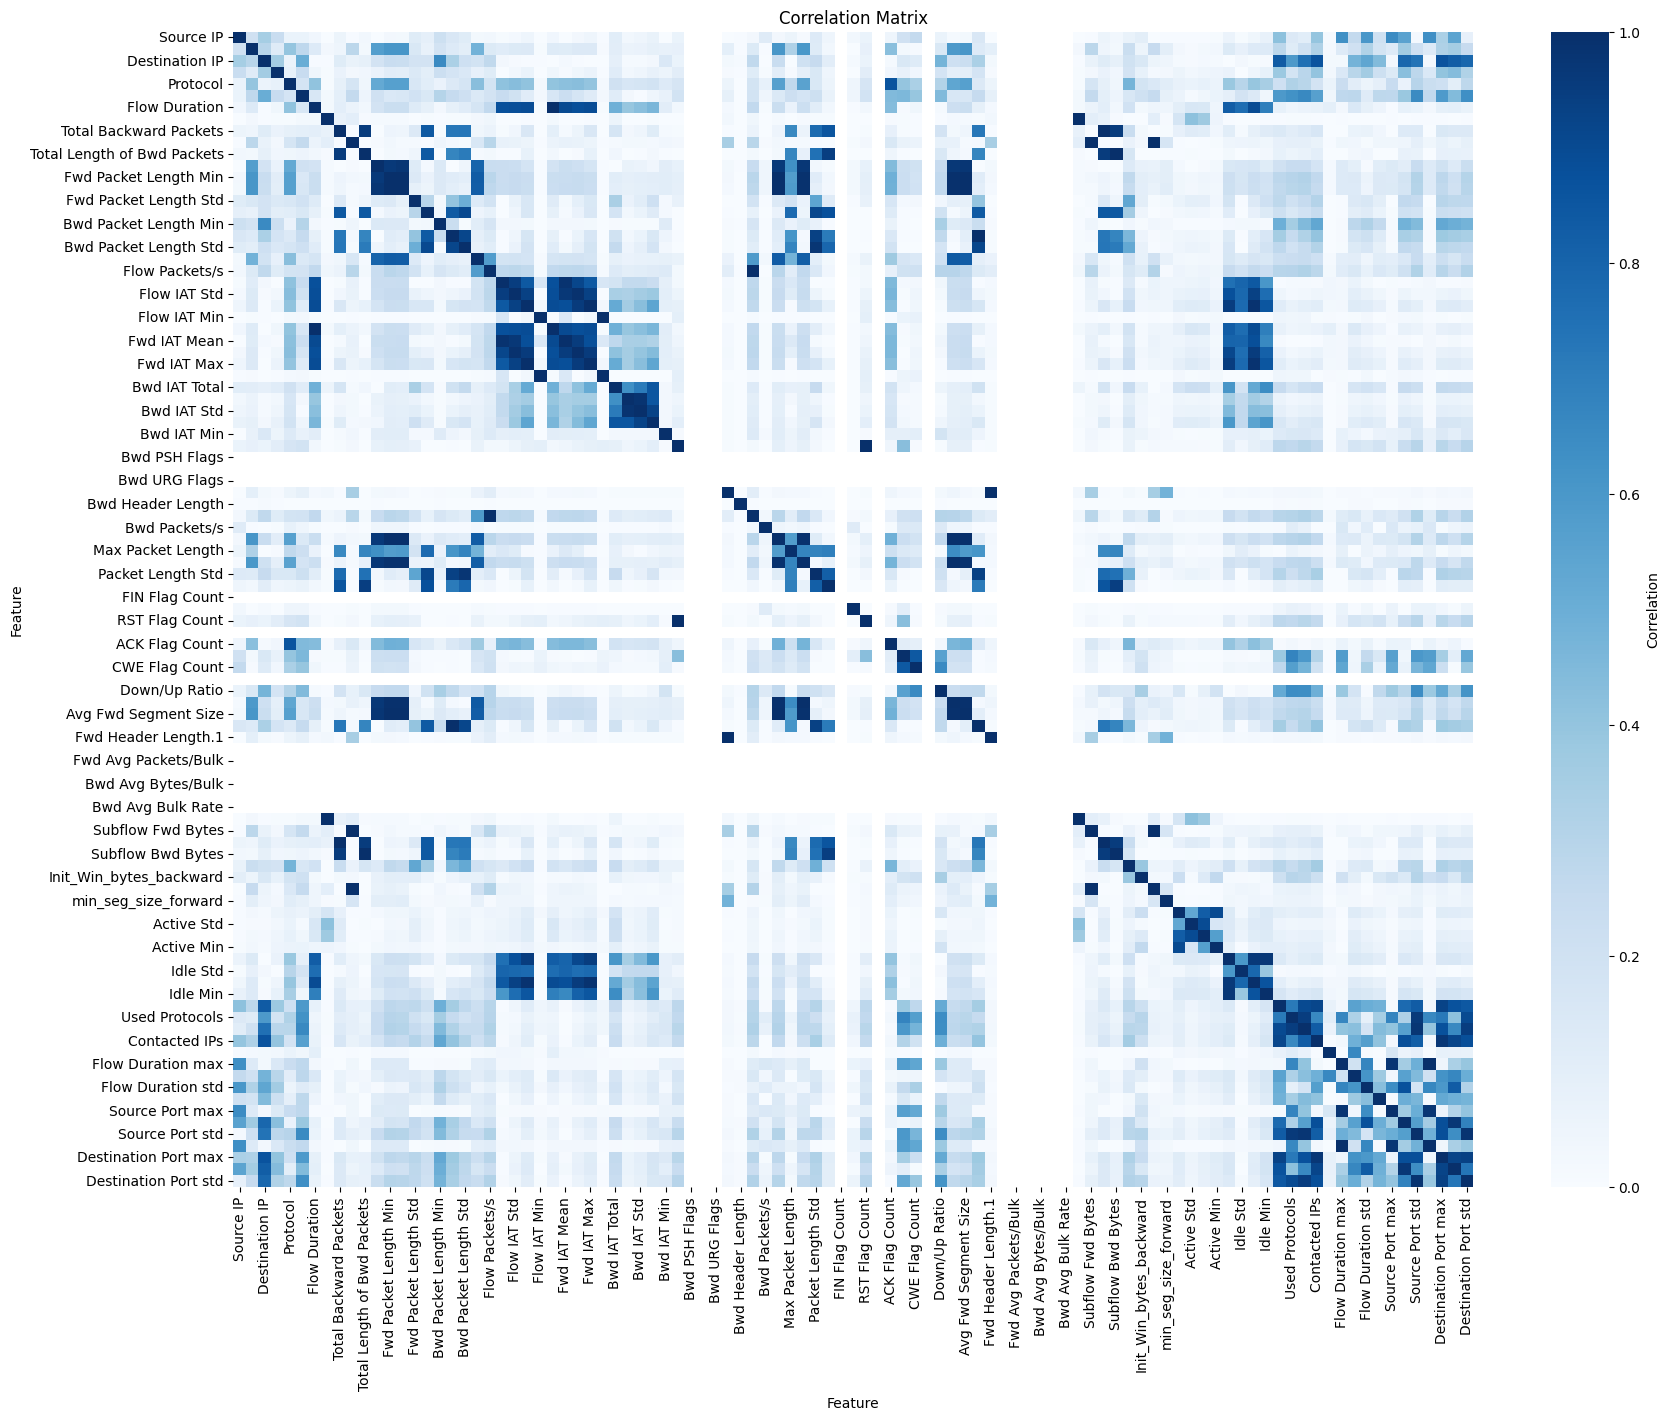

In [5]:
#***************************************************CORRELATION MATRIX********************************************************
def ipToDecimal(x):
    #ipaddress.IPv4Address(x).packed if we ever need binary format
    return int(ipaddress.IPv4Address(x))
df2 = df.copy()

#Timestamp converted to unix-like timestamp. String values are a pain in the.....neck
df2['Timestamp'] = pd.to_datetime(df2['Timestamp']).astype('int64') // 10**9
df2['Source IP'] =  df2['Source IP'].apply(ipToDecimal)
df2['Destination IP'] =  df2['Destination IP'].apply(ipToDecimal)


#Flow ID is a useless field in this case since it cannot be used for groupby (due to how the dataset is structured)
#The label gets dropped because it's a label
#The "Simillar"HTTP (I'm not the one who spelled it wrong) is a string and I don't know how to handle it. I was thinking about mapping it to integer values
#I converted the IP addresses to integers with the help of ipaddress library
correlation_matrix = df2.drop(columns=['label','Flow ID','SimillarHTTP']).corr(method='pearson').abs()

plt.figure(figsize=(20,15))
sns.heatmap(data=correlation_matrix,cmap='Blues',vmin=0,vmax=1,cbar_kws={'label':'Correlation'})
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation Matrix')
plt.show()


### PCA
To clean the dataset from highly correlated features we standardize the features and then we use the principal component analysis.

We also remove the label and the flow ID since it's a feature that derives from a combination of other features like source/dest ip and source/dest port

In [18]:
#***********************************PCA************************************

scaler = StandardScaler()
df_scaled = df2.drop(columns=['label','Flow ID','SimillarHTTP'])
scaled_col = df_scaled.columns
df_scaled[scaled_col] = scaler.fit_transform(df_scaled[scaled_col])

pca = PCA(random_state=10)
pca.fit(df_scaled[scaled_col])


PCA(random_state=10)

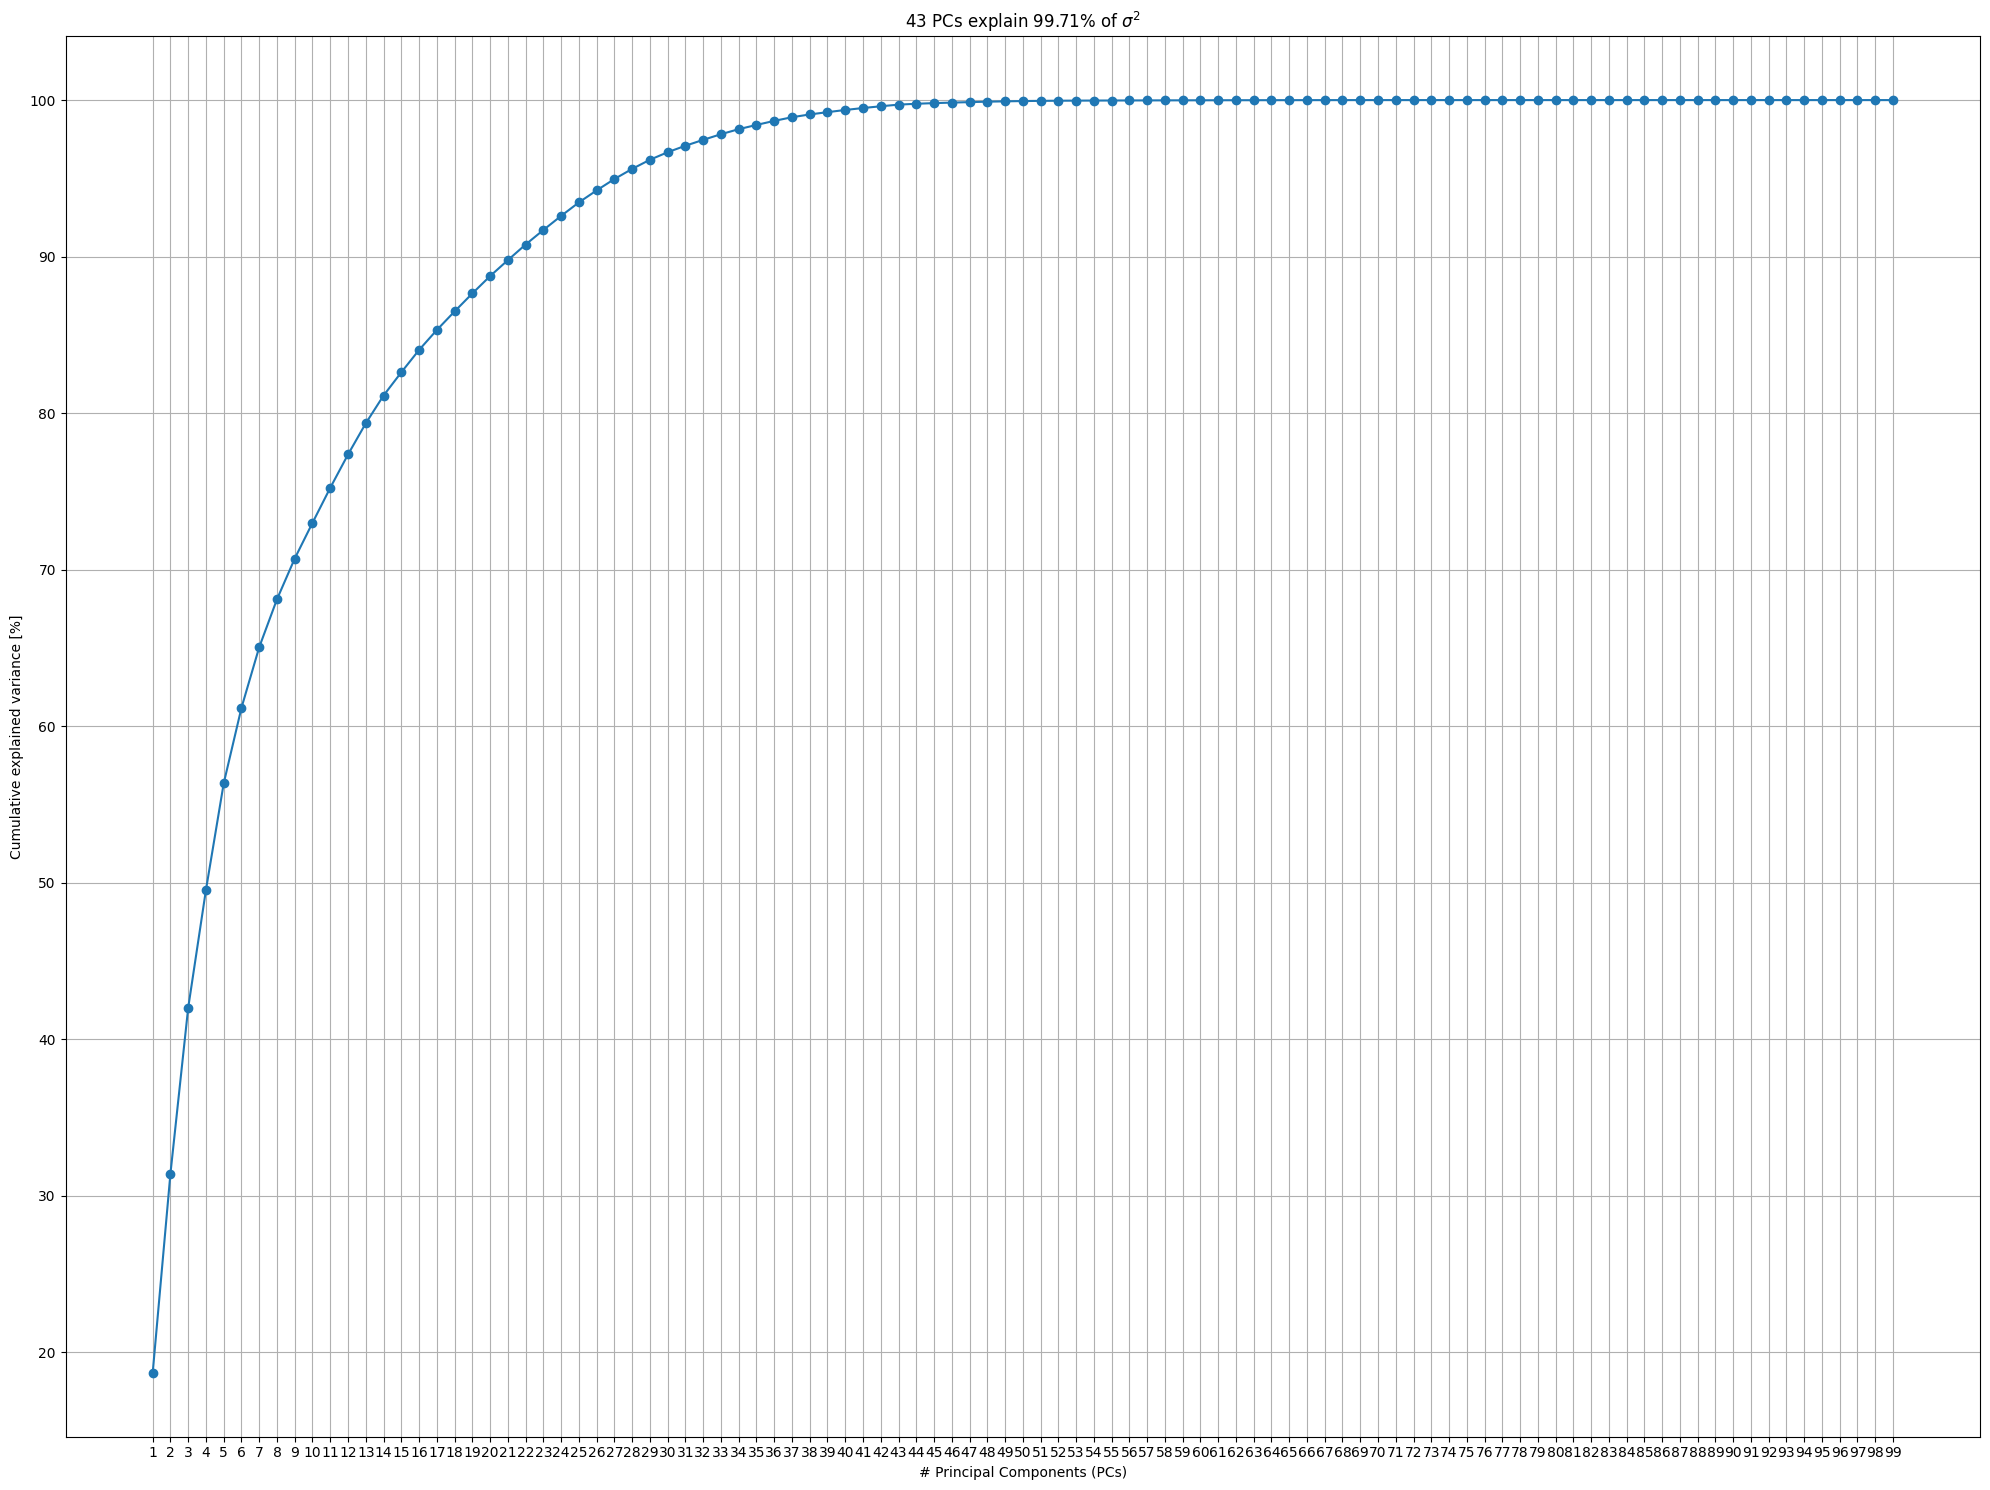

In [19]:
explained_variance_ratio = pca.explained_variance_ratio_
perc_cumul_exp_var_ratio = np.cumsum(explained_variance_ratio) * 100

plt.figure(figsize=(20,15))
plt.plot(perc_cumul_exp_var_ratio, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(len(explained_variance_ratio))], [i for i in range(1,len(explained_variance_ratio)+1)])
plt.grid()
plt.title(f'43 PCs explain {round(perc_cumul_exp_var_ratio[42], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()


In [8]:
pca = PCA(n_components=43,random_state=10)
pca.fit(df_scaled[scaled_col])
pca_result = pca.transform(df_scaled[scaled_col])
df_scaled_pca = pd.DataFrame(pca_result, columns=[f'component_{i}' for i in range(1,44)])
df_scaled_pca['label'] = df['label']
df_scaled_pca
df_scaled_pca.to_csv('pca_dataset.csv', index=False)

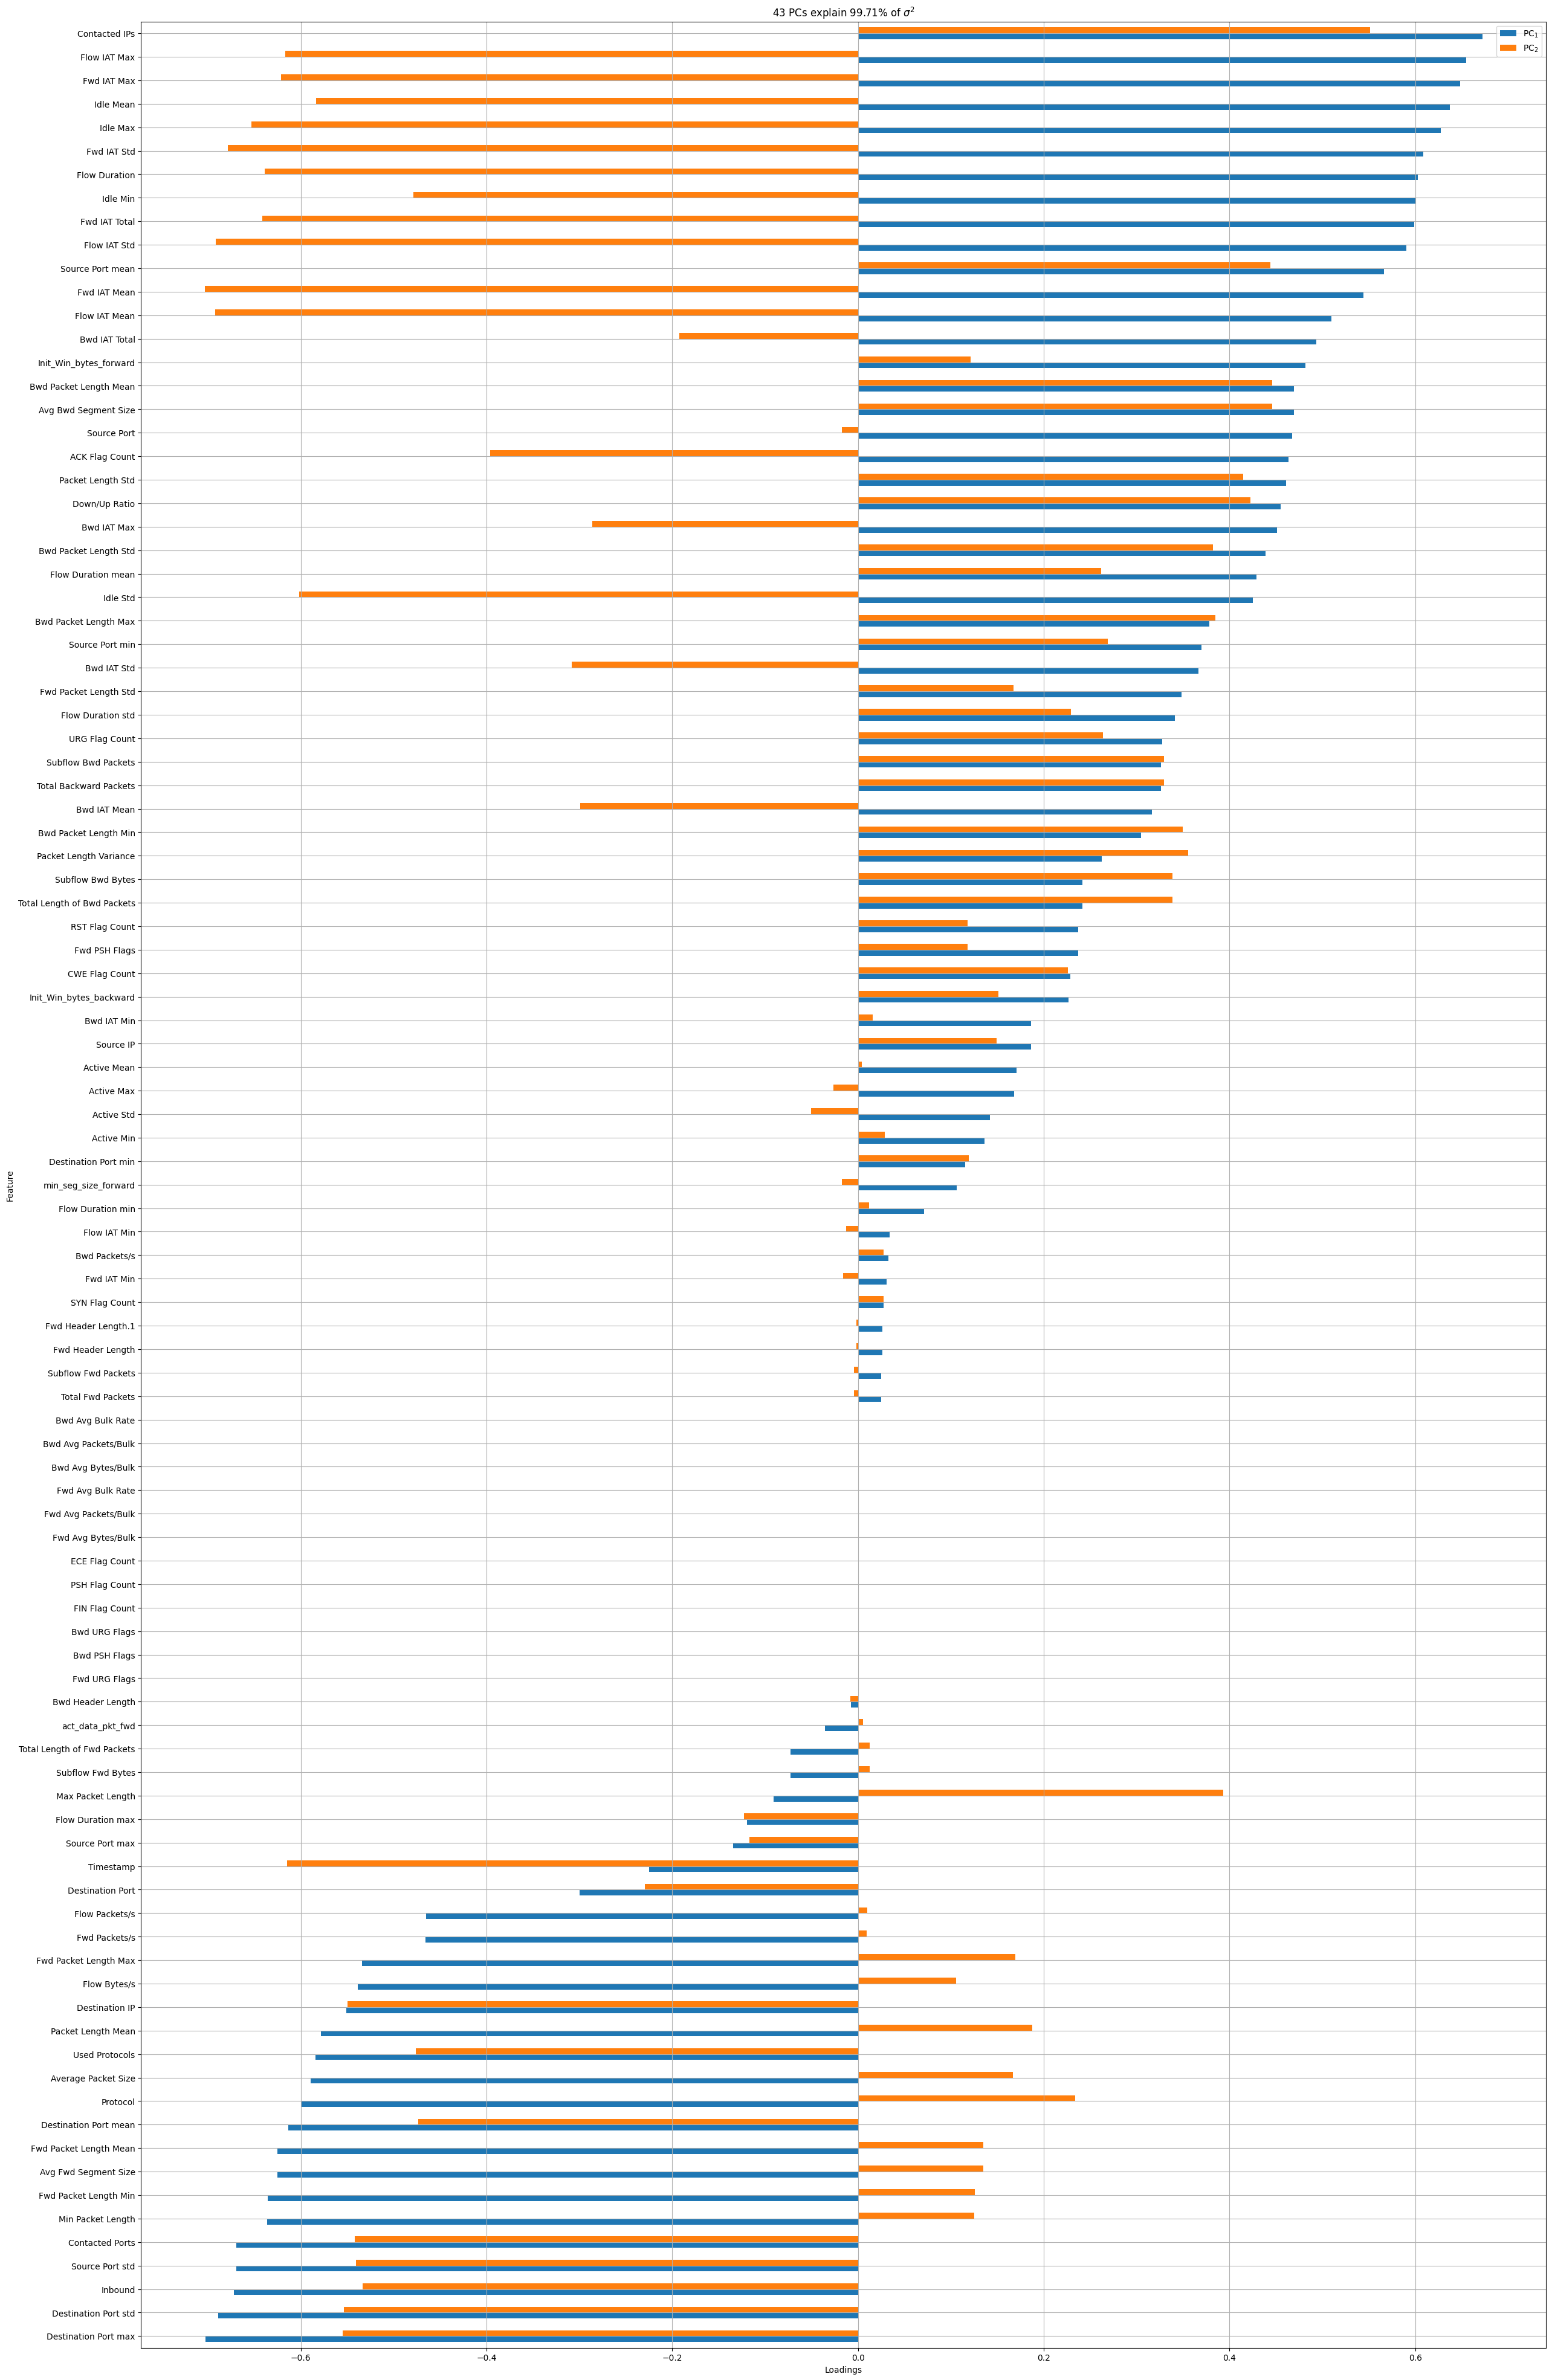

In [9]:
#**********************************************************LOADING SCORES***********************************************
loadings = pd.DataFrame(
    data = pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns = [f'PC{i}' for i in range(1, 44)],
    index = scaled_col
)

plt.figure(figsize=(30,50))
loadings = loadings[['PC1', 'PC2']]
loadings.sort_values(['PC1', 'PC2']).rename(columns={'PC1':'PC$_{1}$', 'PC2':'PC$_{2}$'}).plot.barh(ax=plt.gca())
plt.grid()
plt.xlabel('Loadings')
plt.ylabel('Feature')
plt.title(f'43 PCs explain {round(perc_cumul_exp_var_ratio[42], 2)}% of $\sigma^2$')
plt.show()

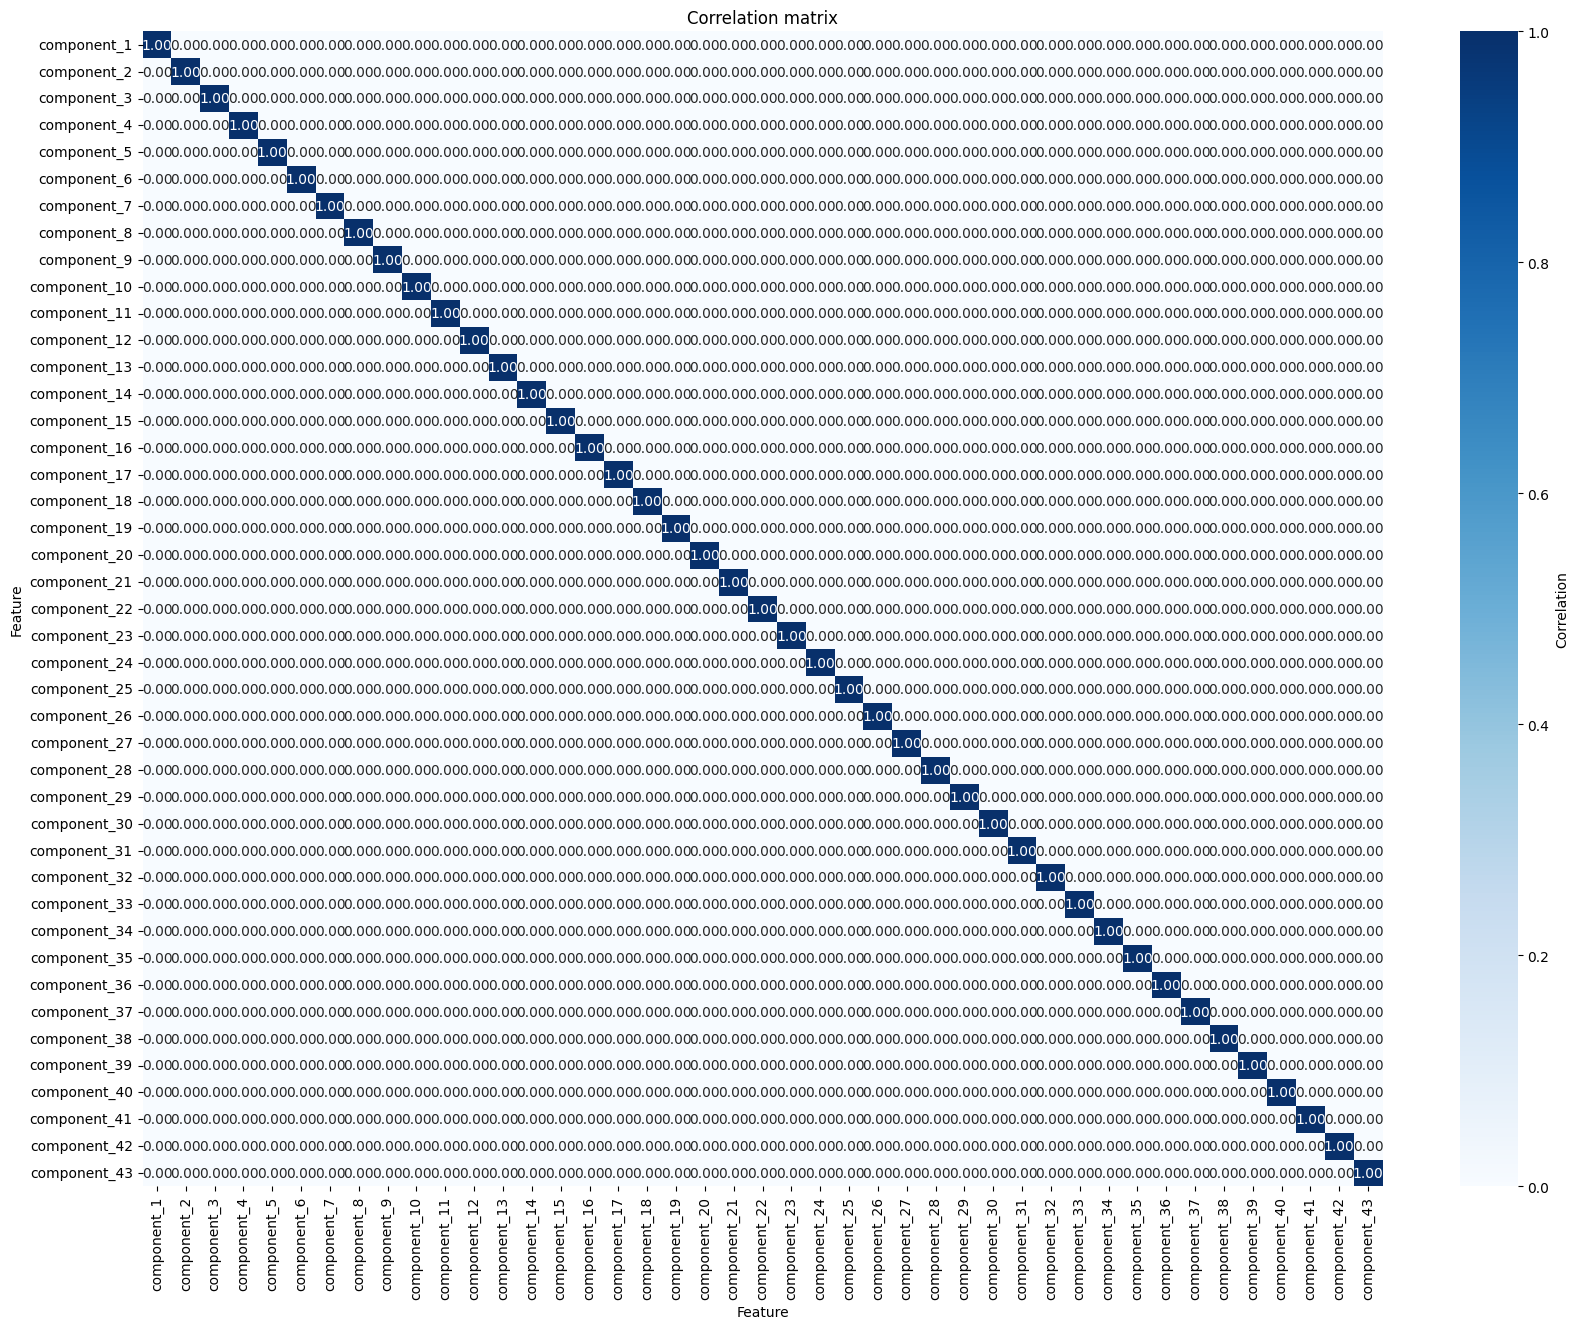

In [10]:
#*********************************************CORRELATION MATRIX AFTER PCA*******************************************
correlation_matrix_pca = df_scaled_pca.drop(columns=['label']).corr().abs()

# Compute the heatmap
plt.figure(figsize=(20,15))
sns.heatmap(correlation_matrix_pca, cmap='Blues',annot=True ,vmin=.0, vmax=1, cbar_kws={'label':'Correlation'}, fmt='.2f')
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation matrix')
plt.show()

### Alternative
Since pca could have problems if the features are not linearly correlated we also used an alternative method learned in class to perform dimensionality reduction by removing iteratively the features with a correlation higher than 0.8.

This gives us also an alternative dataset that we can use to compare the results of algorithms that we will apply on the pca dataset (non so manco io come voglio scriverla sta frase in maniera sensata, poi ci penso)

In [11]:
#****************************************************************DIMENSIONALITY REDUCTION*******************************************
#i should have used dfscaled here not df2 or at least restandardize the data after the dimensionality reduction
correlation_matrix = df2.drop(columns=['label','Flow ID','SimillarHTTP']).corr(method='pearson').abs()

c = correlation_matrix[correlation_matrix > 0.8]

#Unstack returns a series with 2 indexes, the column name and the df index value, and the value corresponding to this pair
#So basically you have a series with index = pair of features and value = correlation value
s = c.unstack()

#Turn it back into a dataframe with 3 columns: feature A, feature B, correlation between featureA and featureB
so = s.sort_values(ascending=False).reset_index()


# Remove correlation between one feature and itself and remove NaN 
so = so[(so[0].isnull()==False) & (so["level_0"] != so["level_1"])]

#Initialization of the list of features that will be removed
to_be_deleted = []

#At the beginning every feature is candidated to be removed
candidates = list(so["level_0"])

# Discard one feature per time considering the case where the feature is strongly correlated with multiple features
subset_so = so
#We iterate over the candidates and see if they are in the list subset_so(=so at the beginning) that we built taking the features with correlation > 0.8.
#Of course the first one gets always deleted.
for candidate in candidates:
    if (candidate in list(subset_so["level_0"])): 
        # add the feature to the list of features we will remove
        to_be_deleted.append(candidate) 
        #Update the subset_so removing the rows in which the removed feature is involved
        subset_so = subset_so[(subset_so["level_0"] != candidate) & (subset_so["level_1"] != candidate)] 

print(len(to_be_deleted), 'features to be removed')
print(to_be_deleted)


50 features to be removed
['Fwd Header Length', 'RST Flag Count', 'Avg Fwd Segment Size', 'Subflow Bwd Bytes', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets', 'Total Backward Packets', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Avg Bwd Segment Size', 'Min Packet Length', 'Fwd Packet Length Min', 'Fwd IAT Total', 'Flow Duration', 'Flow Packets/s', 'Flow IAT Min', 'Flow IAT Max', 'Fwd IAT Max', 'Flow Duration max', 'Destination Port min', 'Average Packet Size', 'Packet Length Mean', 'Flow IAT Std', 'Fwd IAT Std', 'Flow IAT Mean', 'Fwd IAT Mean', 'Idle Max', 'Destination Port std', 'Source Port std', 'Bwd IAT Std', 'Bwd IAT Mean', 'Bwd Packet Length Std', 'Packet Length Std', 'Contacted Ports', 'Source Port mean', 'Destination Port mean', 'Contacted IPs', 'Destination Port max', 'Idle Mean', 'Packet Length Variance', 'Inbound', 'Bwd IAT Max', 'Active Min', 'Active Mean', 'Active Max', 'ACK Flag Coun

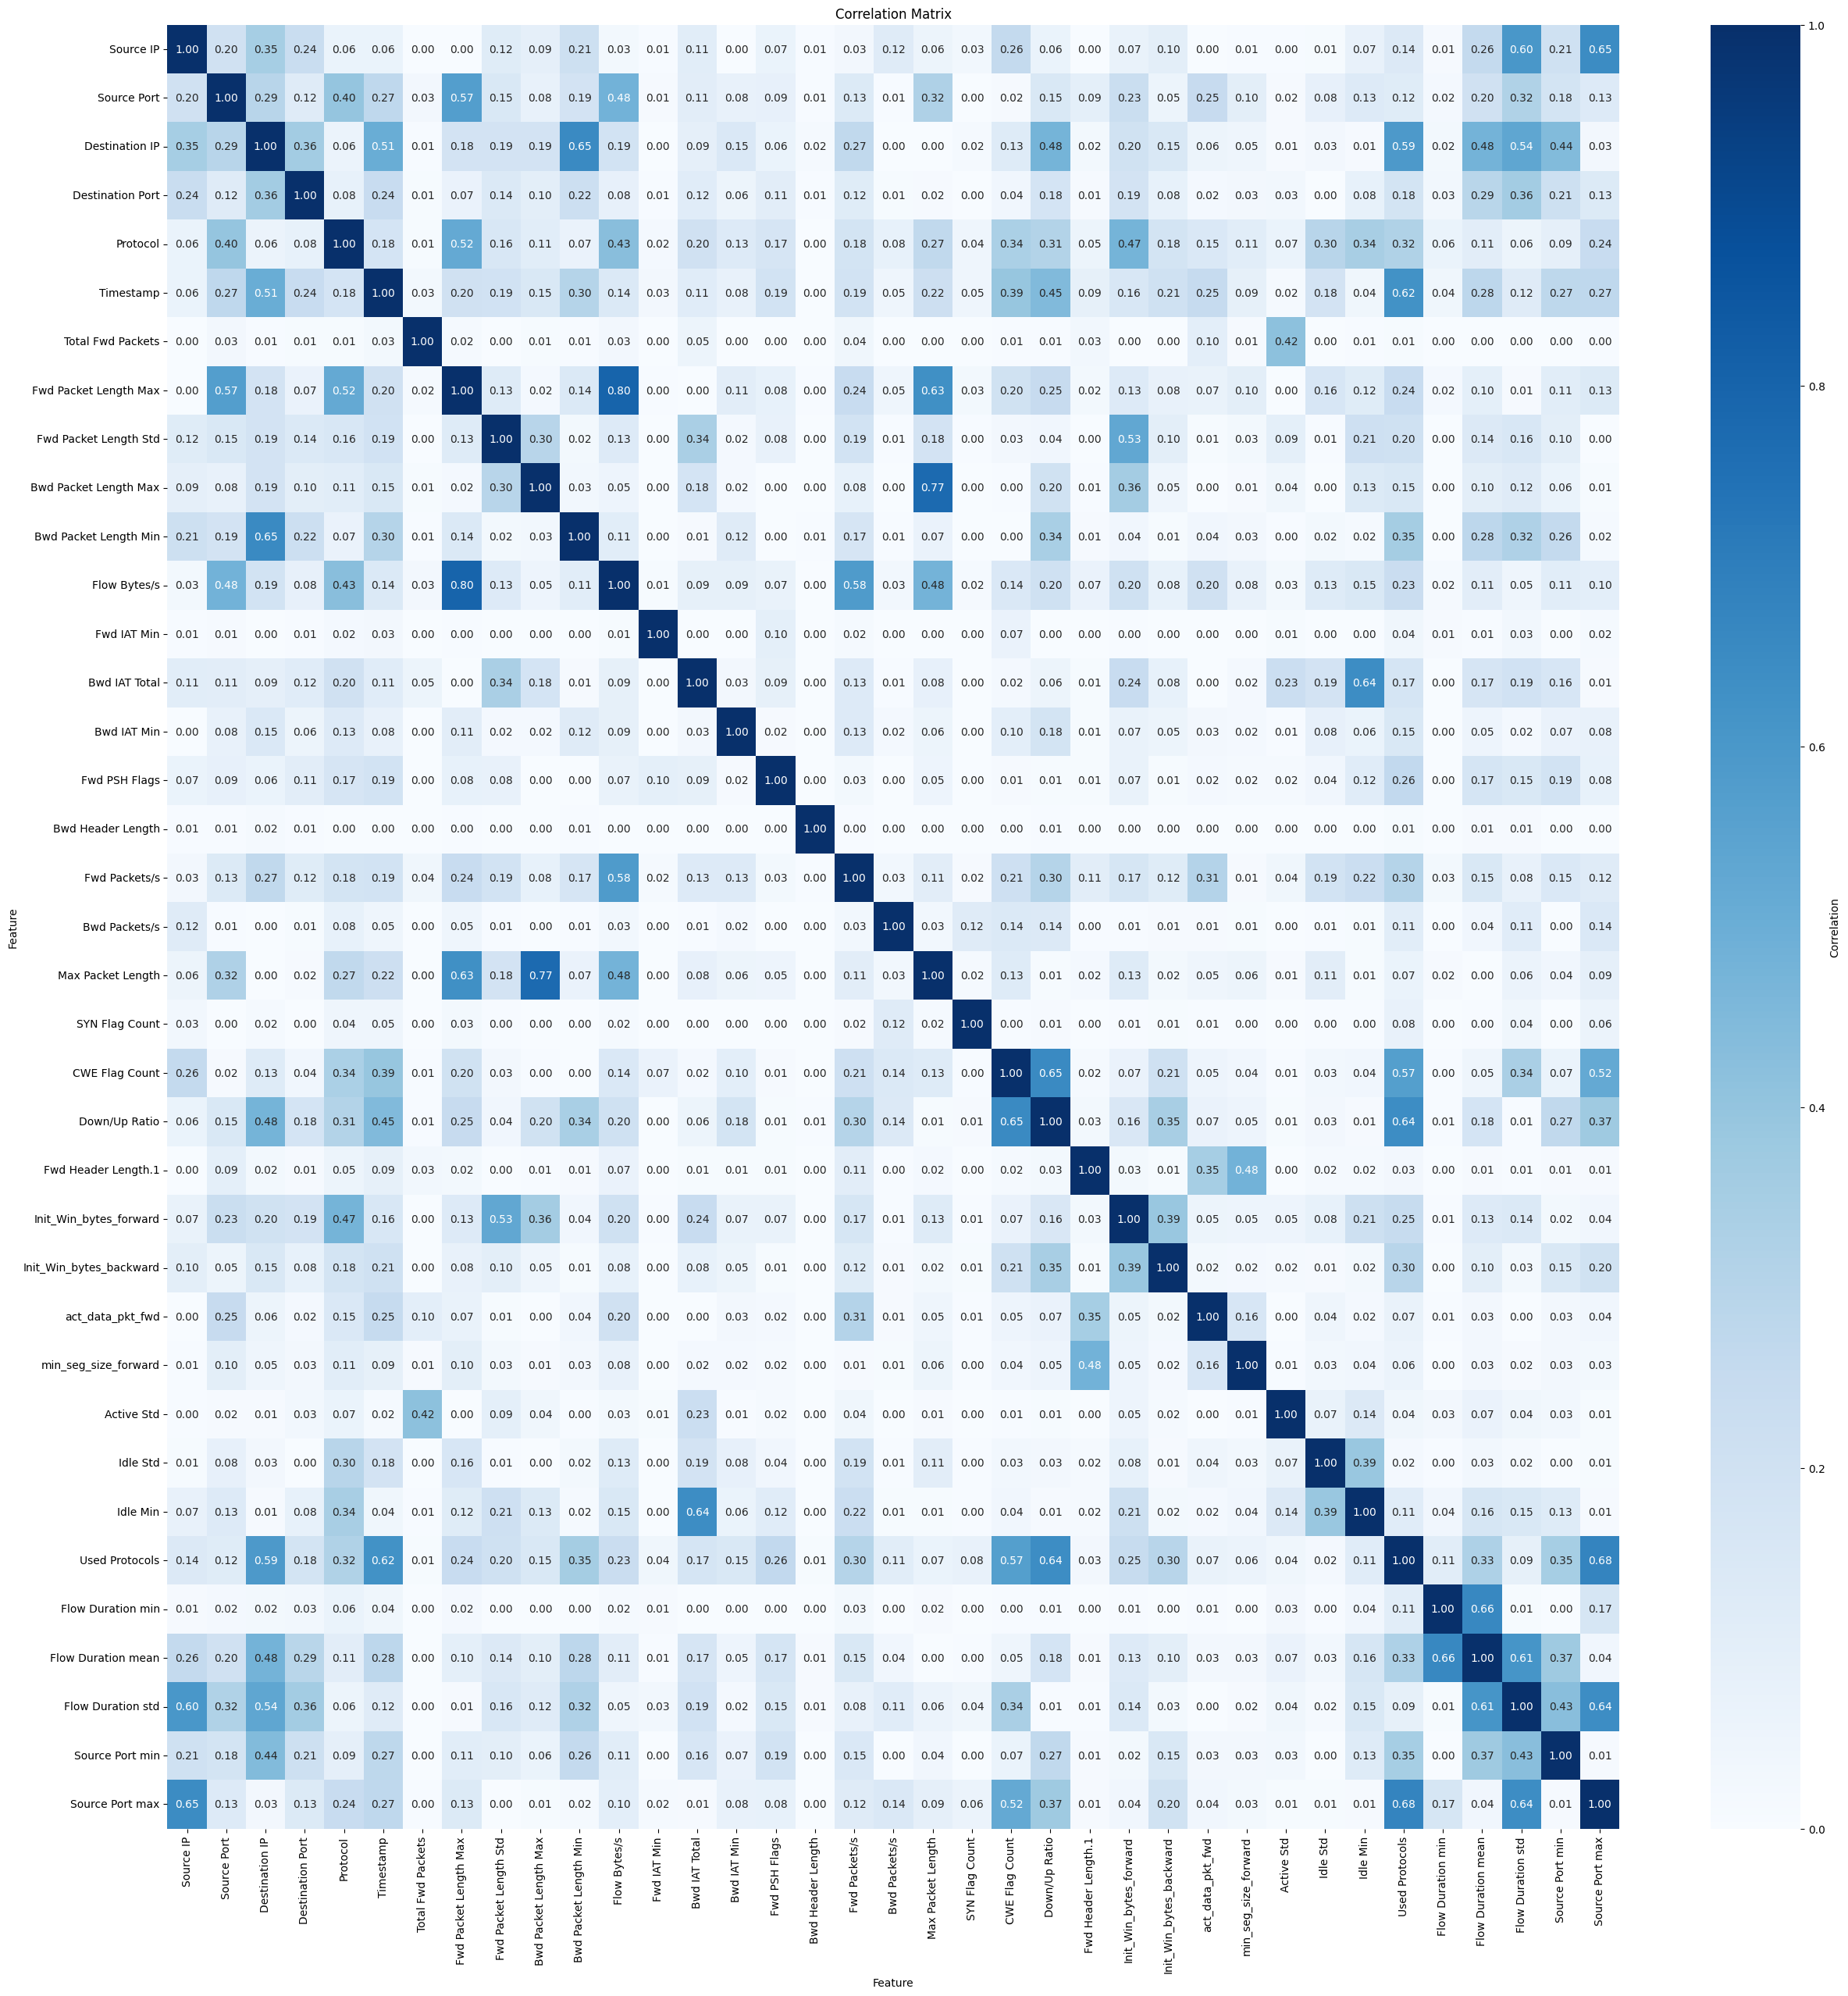

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Total Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Std,Bwd Packet Length Max,...,Idle Std,Idle Min,Used Protocols,Flow Duration min,Flow Duration mean,Flow Duration std,Source Port min,Source Port max,SimillarHTTP,label
0,-0.036507,-0.996890,0.246218,1.463534,0.560382,-0.981283,0.169121,-0.297075,-0.172277,-0.069596,...,-0.165955,-0.194882,0.310559,-0.022062,-0.139123,-0.057041,-0.144334,0.132962,0,ddos_dns
1,-0.036507,-0.996890,0.246218,0.770389,0.560382,-0.981283,0.391920,-0.297075,-0.172277,-0.069596,...,-0.165955,-0.194882,0.310559,-0.022062,-0.139123,-0.057041,-0.144334,0.132962,0,ddos_dns
2,-0.036507,-0.996890,0.246218,-0.924976,0.560382,-0.981283,0.391920,-0.297075,-0.172277,-0.069596,...,-0.165955,-0.194882,0.310559,-0.022062,-0.139123,-0.057041,-0.144334,0.132962,0,ddos_dns
3,-0.036507,-0.996890,0.246218,-0.139438,0.560382,-0.981283,0.391920,-0.297075,-0.172277,-0.069596,...,-0.165955,-0.194882,0.310559,-0.022062,-0.139123,-0.057041,-0.144334,0.132962,0,ddos_dns
4,-0.036507,-0.996890,0.246218,0.807641,0.560382,-0.981283,0.391920,-0.297075,-0.172277,-0.069596,...,-0.165955,-0.194882,0.310559,-0.022062,-0.139123,-0.057041,-0.144334,0.132962,0,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,-9.970104,-1.004619,0.246218,1.261252,-1.777077,-2.044702,-0.034209,-0.983448,0.261562,-0.069596,...,-0.165955,-0.194882,-5.117269,-0.021294,-1.580701,-5.203844,-0.079823,-7.545412,0,benign
64235,-9.970104,-1.004619,0.246218,1.261350,-1.777077,-2.044702,-0.034209,-0.983448,0.261562,-0.069596,...,-0.165955,-0.194882,-5.117269,-0.021294,-1.580701,-5.203844,-0.079823,-7.545412,0,benign
64236,-10.842294,-1.004619,0.246218,1.261694,-1.777077,-2.043498,-0.034209,-0.995400,0.181644,-0.069596,...,-0.165955,-0.194882,-5.117269,-0.022059,-1.580912,-5.203815,-0.079823,-7.545412,0,benign
64237,-10.842294,-1.004619,0.246218,1.261694,-1.777077,-2.043498,-0.038535,-1.048329,-0.172277,-0.069596,...,-0.165955,-0.194882,-5.117269,-0.022059,-1.580912,-5.203815,-0.079823,-7.545412,0,benign


In [12]:
df_cleaned = df2.copy().drop(columns=to_be_deleted)
all_zeros = (df_cleaned == 0).all(axis=0)
df_cleaned = df_cleaned.loc[:, ~all_zeros]

cleaned_correlation_matrix = df_cleaned.drop(columns=['label','Flow ID','SimillarHTTP']).corr(method='pearson').abs()

plt.figure(figsize=(30,30))
sns.heatmap(data=cleaned_correlation_matrix,cmap='Blues',annot=True,vmin=0,vmax=1,cbar_kws={'label':'Correlation'},fmt='.2f')
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation Matrix')
plt.show()

df_cleaned.to_csv('cleaned_dataset.csv', index=False)

# df_cleaned.columns
scaler = StandardScaler()
df_cleaned_scaled = df_cleaned.drop(columns=['label','Flow ID','SimillarHTTP'])
df_cleaned_scaled = scaler.fit_transform(df_cleaned_scaled)

dcs_columns = [col_name for col_name in df_cleaned.columns if col_name not in ['label','Flow ID','SimillarHTTP']]
df_cleaned_scaled = pd.DataFrame(df_cleaned_scaled,columns=dcs_columns)

df_cleaned_scaled[['SimillarHTTP','label']]= df_cleaned[['SimillarHTTP','label']].copy()
df_cleaned_scaled.to_csv('cleaned_scaled_dataset.csv', index=False)
df_cleaned_scaled